In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import scipy.linalg

from k4 import *

plt.rc("text", usetex=False)
plt.rc("font", family = "serif",size=14)
plt.rc("figure",figsize=(12,10))
%config InlineBackend.figure_format = 'retina'

In [2]:
# equilibrium parameters

labels_f, labels_r = eq_params_k4()
print(labels_f)
print(labels_r)

[161.8, 0.1404, 24.4, 4.353]
[89.68, 0.01938, 2.261, 614.0082180863711]


In [3]:
labels_f_eq = labels_f.copy()
labels_r_eq = labels_r.copy()

print(labels_f_eq)
print(labels_r_eq)

[161.8, 0.1404, 24.4, 4.353]
[89.68, 0.01938, 2.261, 614.0082180863711]


In [4]:
aff = np.abs(np.log(np.prod(labels_f_eq)/np.prod(labels_r_eq)))
print(aff)

0.0


In [5]:
# autocorr settings
signal = [3,5,7,9]
alpha, beta  = 1, 3

In [6]:
# arrays for tracking aff, area, and eigs
N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
eigvals_all_r = np.zeros((N, 4), dtype=float)
eigvals_all_c = np.zeros((N, 4), dtype=float)

# edge to perturb
edge_idx = 1
perturb_edge = labels_f_eq[edge_idx] # labels_f[1] = k23

for i in tqdm(range(0,N)):
    
    labels_f_eq[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f_eq, labels_r_eq)
    
    aff = np.abs(np.log(np.prod(labels_f_eq)/np.prod(labels_r_eq)))
    affinities[i] = aff
    
    tau, _ = define_tau_range(lap, max_points=500, cap_factor=10.0)
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapezoid(a13)-np.trapezoid(a31))
    
    # Track eigenvalues (real part)
    eigvals = scipy.linalg.eigvals(lap)
    eigvals_all_r[i, :] = np.sort(eigvals.real)
    eigvals_all_c[i, :] = np.sort(eigvals.imag)
    
    perturb_edge *= 1.01

100%|██████████████████████████████████████| 2000/2000 [00:17<00:00, 115.86it/s]


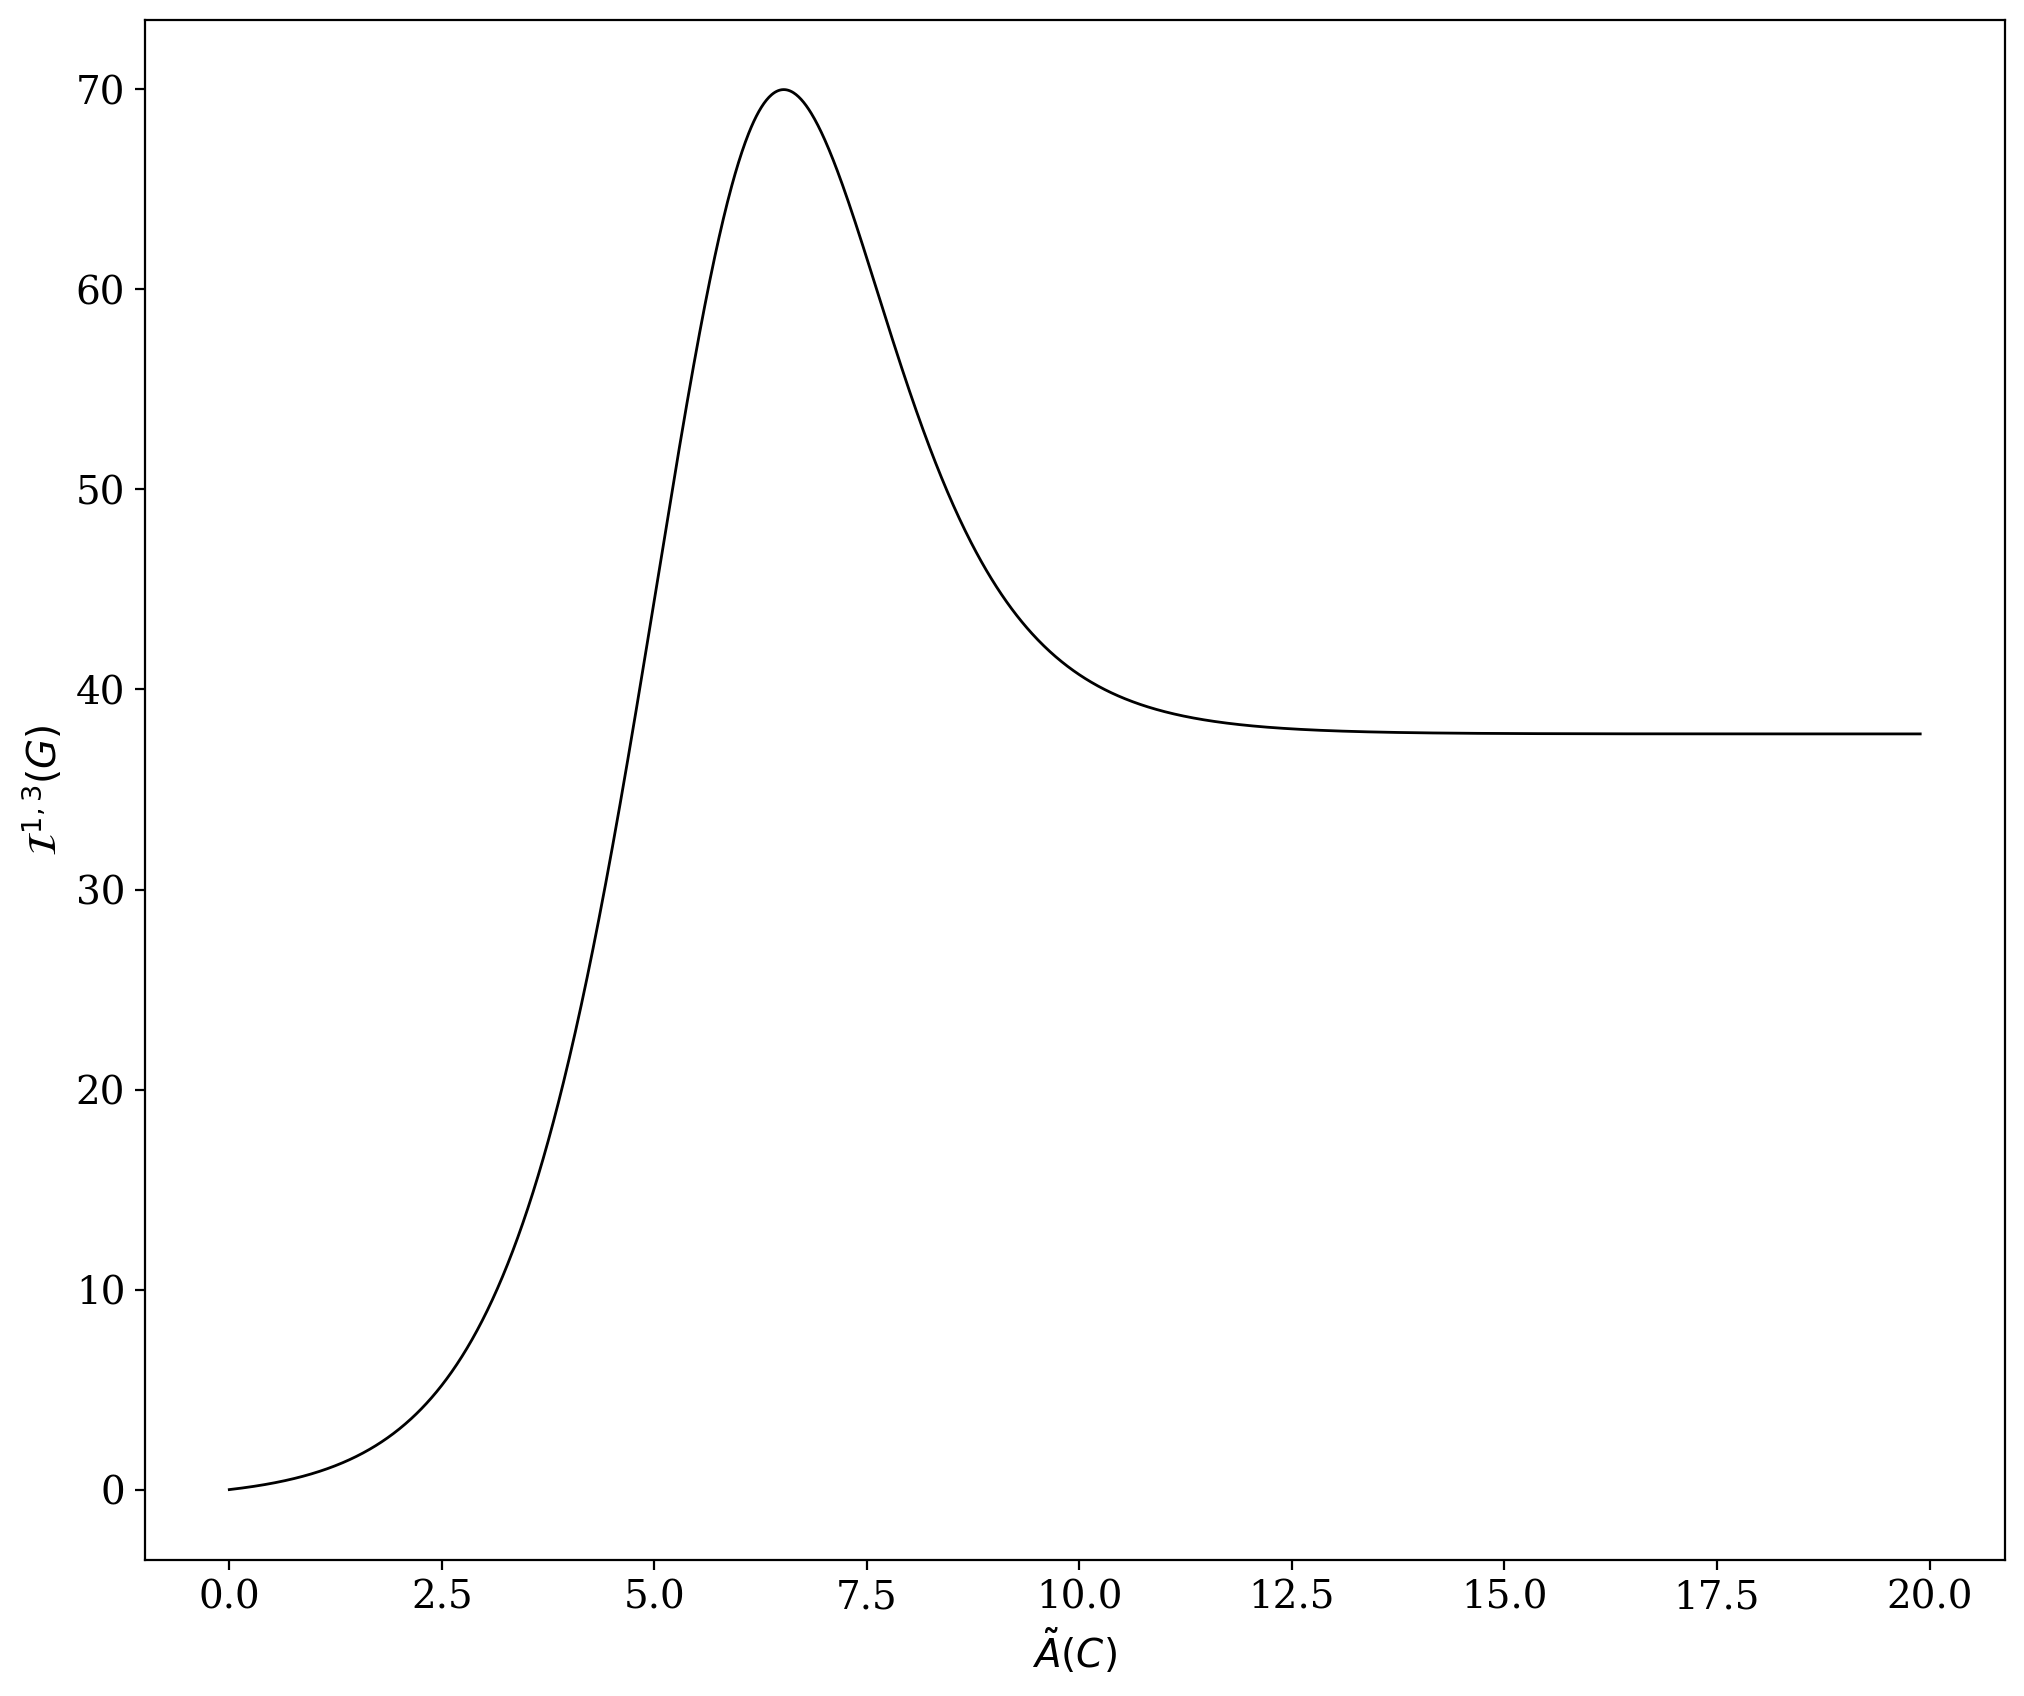

In [7]:
# Steinberg curve plot
plt.plot(np.abs(affinities),areas,label=r'$\mathcal{I}^{1,3}(G)$',linewidth=1, color= 'black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.show()

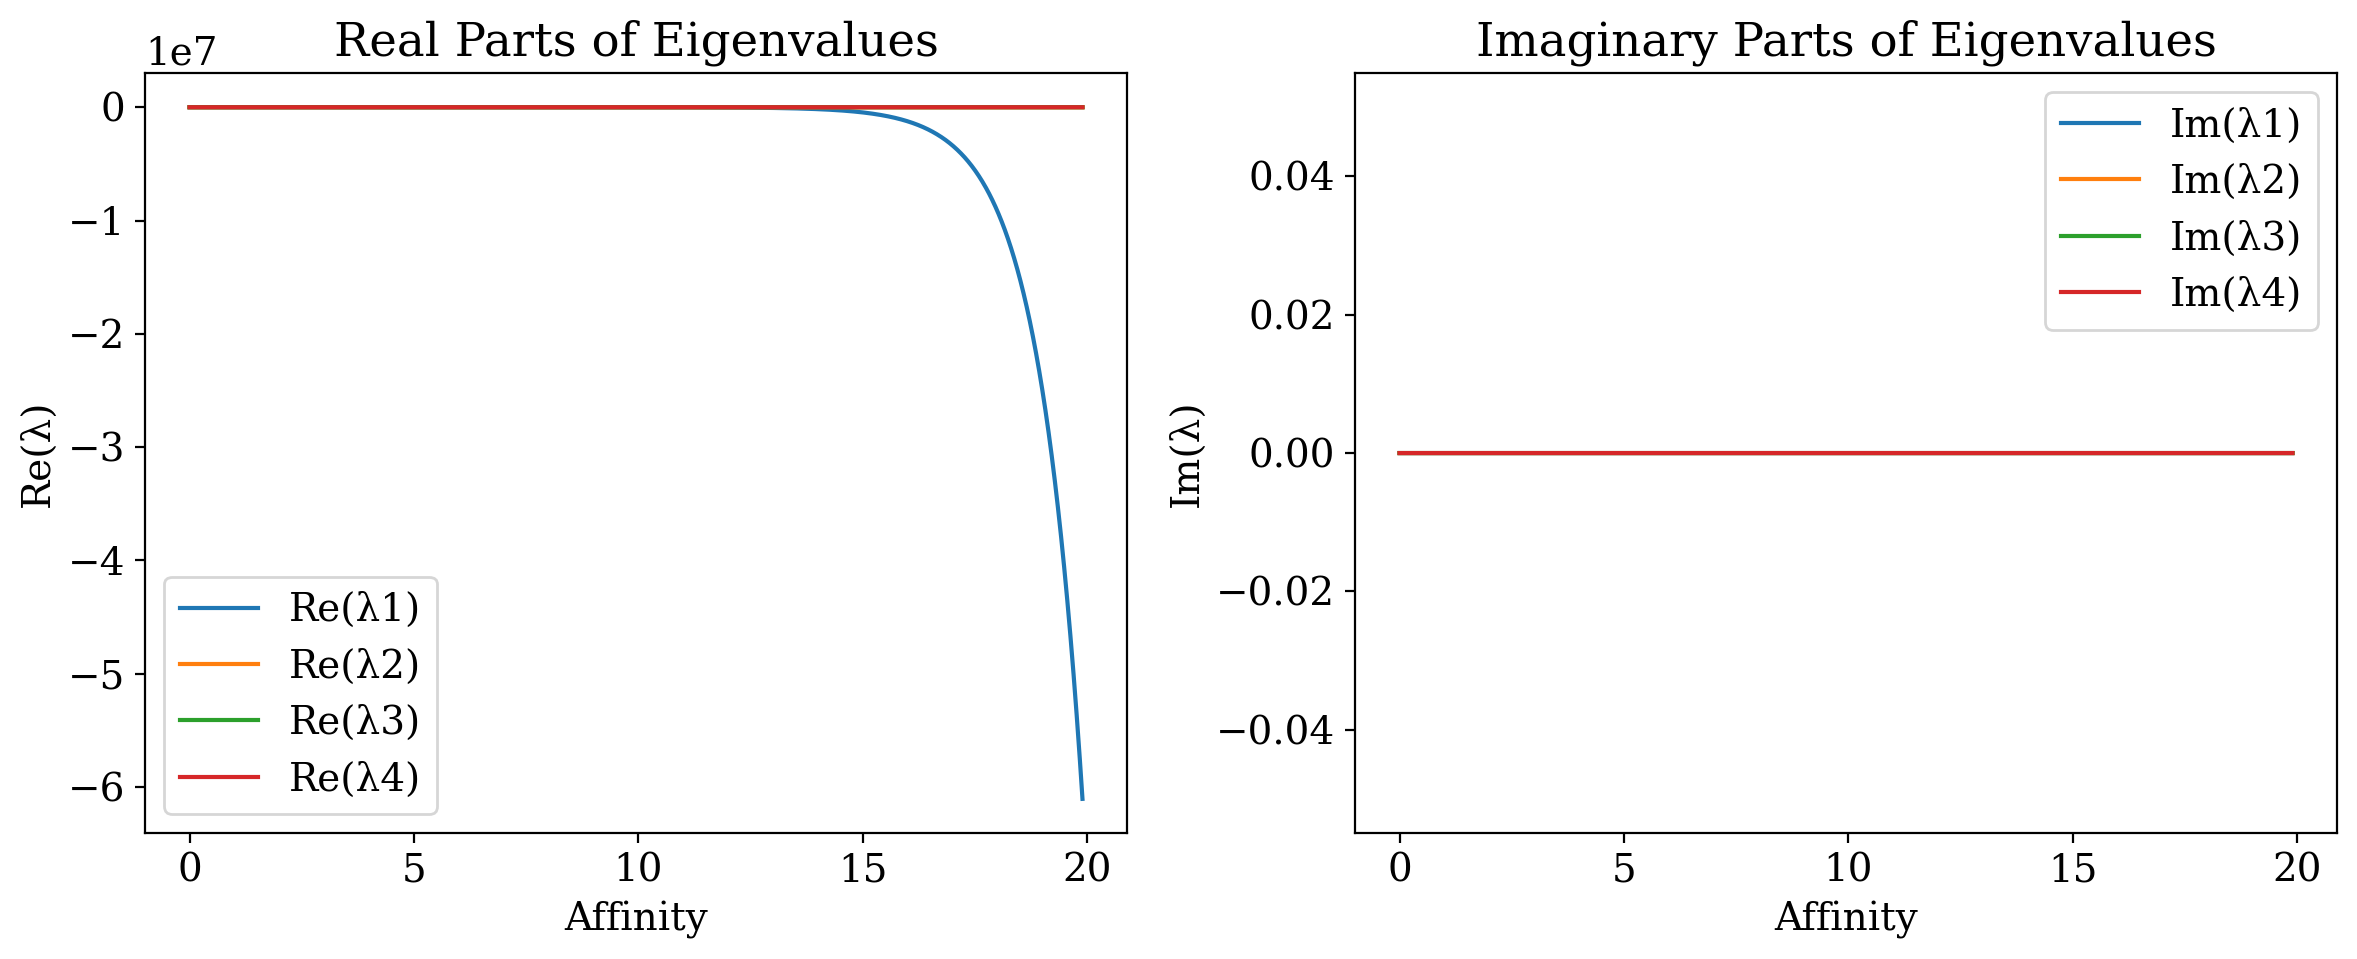

In [8]:
# Eigenvalues plots
plt.figure(figsize=(12,5))

# Real part
plt.subplot(1,2,1)
for j in range(4):
    plt.plot(affinities, eigvals_all_r[:, j], label=f"Re(λ{j+1})")
plt.xlabel("Affinity")
plt.ylabel("Re(λ)")
plt.title("Real Parts of Eigenvalues")
plt.legend()

# Imaginary part
plt.subplot(1,2,2)
for j in range(4):
    plt.plot(affinities, eigvals_all_c[:, j], label=f"Im(λ{j+1})")
plt.xlabel("Affinity")
plt.ylabel("Im(λ)")
plt.title("Imaginary Parts of Eigenvalues")
plt.legend()

plt.tight_layout()
#plt.savefig(f"eigenvalue_evolution_edge_{edge_idx}.png", dpi=300)
plt.show()

In [165]:
def spectrum_any(lap, tol=1e-12):
    symmetric = np.allclose(lap, lap.T, atol=tol)
    
    eigvals_u, l_eigvecs_u, r_eigvecs_u = scipy.linalg.eig(lap, left=True, right=True)

    if symmetric:
        # Clean up tiny numerical imaginary parts for symmetric case
        eigvals_u = eigvals_u.real
        r_eigvecs_u = r_eigvecs_u.real
        l_eigvecs_u = l_eigvecs_u.real
        
    idx = np.argsort(eigvals_u.real)
    lambdas = eigvals_u[idx]
    z_i = r_eigvecs_u[:, idx]
    l_eigvecs_u = l_eigvecs_u[:, idx]

    # Left eigenvectors as rows (conjugate transpose)
    w_i = l_eigvecs_u.conj().T
    
    return lambdas, w_i, z_i

In [166]:
def pi_dist(lap):
    """
    Computes the steady-state distribution directly from the spectrum of a given Laplacian matrix. This function works for a linear framework graph of any size.
    """
    eigvals, eigvecs = scipy.linalg.eig(lap)
    v = eigvecs[:, np.argmin(np.abs(eigvals))].real
    pi = v / v.sum()
    return pi

In [167]:
def normalization_factors(w_i, z_i):
    r_i = np.zeros(z_i.shape[1], dtype=complex)  # one factor per eigenpair
    for k in range(z_i.shape[1]):
        r_i[k] = np.vdot(w_i[k,:], z_i[:, k])  # vdot does conjugate on first arg
    return r_i

In [168]:
def projection_matrices(w_i, z_i, r):
    N = z_i.shape[0]
    m = z_i.shape[1]  # number of eigenpairs
    Lk_list = []
    for k in range(m):
        zk = z_i[:, [k]]   # column vector (N x 1)
        wk = w_i[[k], :]   # column vector (N x 1)
        Lk = (1 / r[k]) * (zk @ wk)  # outer product gives N x N
        Lk_list.append(Lk)
    return Lk_list

In [169]:
def B_matrix(lambdas, Lk_list, delta_u_star):
    N = delta_u_star.shape[0]
    print(N)
    # skip k=0 since lambdas[0] is zero for Laplacian
    Bsum = sum((1/lambdas[k]) * Lk_list[k] for k in range(0, N-2))
    return Bsum @ delta_u_star

In [170]:
def skew_symmetric_area(signal, B, alpha=1,beta=3):
    """
    Computes the Steinberg signature / area for given vectors S_alpha, S_beta
    and the operator B(G).
    """
    # define the signal vectors
    s_t = np.array([signal],dtype=float) # row vector
    s = s_t.T # column vector
    
    # Form the skew-symmetric combination
    B_skew = B - B.T
    area = (s_t**beta) @ B_skew @ (s ** alpha)
    return area

In [171]:
def steinberg_analytical_area(signal,lap,alpha=1,beta=3):
    lambdas, w_i, z_i = spectrum_any(lap)
    r_i = normalization_factors(w_i, z_i)
    Lk_list = projection_matrices(w_i, z_i, r_i)
    pi = np.array(pi_dist(lap))
    delta_u_star = np.diag(pi)
    B = B_matrix(lambdas, Lk_list, delta_u_star)
    area = skew_symmetric_area(signal, B, alpha=1,beta=3)

    return area.item()

In [172]:
labels_f, labels_r = eq_params_k4()

aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
print(aff)

lap = lap_k4(labels_f, labels_r)
print(lap)

signal = [3,5,7,9]
alpha, beta  = 1, 3

area = steinberg_analytical_area(signal,lap,alpha=1,beta=3)
print(area)

0.0
[[-1.14553412e-01  3.90900000e-02  0.00000000e+00  3.53400000e-02]
 [ 2.87000000e-02 -1.76190900e+01  2.41800000e-01  0.00000000e+00]
 [ 0.00000000e+00  1.75800000e+01 -3.64318000e+01  7.95200000e+02]
 [ 8.58534116e-02  0.00000000e+00  3.61900000e+01 -7.95235340e+02]]
4
(-3.847918001687544e-15+0j)


Note: ```scipy.linalg.eig``` solves a generalized eigensystem problem, and sometimes that results in numerical artifacts appearing in the imaginary parts of the eigenvalues and eigenvectors.

In [154]:
print(labels_f, labels_r)

[0.01325, 0.1688, 351.9, 0.1475] [0.03629, 719.2, 0.1963, 0.022659100267141484]


In [155]:
print(lap)

[[-3.59091003e-02  3.62900000e-02  0.00000000e+00  1.47500000e-01]
 [ 1.32500000e-02 -2.05090000e-01  7.19200000e+02  0.00000000e+00]
 [ 0.00000000e+00  1.68800000e-01 -1.07110000e+03  1.96300000e-01]
 [ 2.26591003e-02  0.00000000e+00  3.51900000e+02 -3.43800000e-01]]


## Sanity checks

Are the eigenvalues/eigenvectors correct? Confirm $w_i \mathcal{L}(G) = \lambda_i w_i$ and  $\mathcal{L}(G) z_i = \lambda_i z_i$.

In [156]:
lambdas, w_i, z_i = spectrum_any(lap)

In [157]:
lambdas

array([-1.07127785e+03+0.j, -3.20043804e-01+0.j, -8.69075481e-02+0.j,
        1.05786531e-15+0.j])

In [158]:
w_i

array([[ 5.82646433e-09, -1.57599000e-04,  9.99999971e-01,
        -1.83297931e-04],
       [-6.60691794e-02, -2.22375991e-01,  1.65643464e-01,
         9.58512402e-01],
       [ 3.02665164e-01, -7.19146072e-01, -5.68567327e-01,
        -2.60679729e-01],
       [ 5.00000000e-01,  5.00000000e-01,  5.00000000e-01,
         5.00000000e-01]])

In [159]:
z_i

array([[ 5.44566420e-05, -3.65703218e-01,  7.51622394e-01,
         9.29716638e-01],
       [-5.37809082e-01, -4.49414082e-01, -6.52053600e-01,
         3.39452892e-01],
       [ 8.00935284e-01,  7.85698362e-05, -1.20995954e-04,
         7.96713685e-05],
       [-2.63180658e-01,  8.15038731e-01, -9.94477989e-02,
         1.42824017e-01]])

In [160]:
print(lambdas[0]*w_i[0,:])

[-6.24176216e-06+0.j  1.68832317e-01-0.j -1.07127782e+03+0.j
  1.96363013e-01-0.j]


In [161]:
print(w_i[0,:]@lap)

[-6.24176217e-06  1.68832317e-01 -1.07127782e+03  1.96363013e-01]


In [162]:
print(lambdas[0]*z_i[:,0])

[-5.83381942e-02+0.j  5.76142956e+02-0.j -8.58024227e+02+0.j
  2.81939609e+02-0.j]


In [163]:
print(lap@z_i[:,0])

[-5.83381942e-02  5.76142956e+02 -8.58024227e+02  2.81939609e+02]


## Sanity checks

Does $\sum_{k=1}^N L^{(k)} = I$?

In [112]:
r_i = normalization_factors(w_i, z_i)
Lk_list = projection_matrices(w_i, z_i, r_i)
np.allclose(sum(Lk_list), np.eye(4))

True

In [117]:
len(Lk_list)

4